In [195]:
import os
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import SortedNoDupeBedOverlap as bdO

import pandas as pd
import numpy as np
import csv

import scipy

import yaml
import getopt, sys

import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from multiprocessing import Pool


In [196]:
full_cmd_arguments = sys.argv
argument_list = full_cmd_arguments[1:]
short_options = "i:r:b:f:vom"
long_options = ["input=", "ref_folder=", "background=","figure_cols=", "verbose", "output","multiple_processing"]

try:
    arguments, values = getopt.getopt(argument_list, short_options, long_options)
except getopt.error as err:
    print (str(err))
    sys.exit(2)
    
figure = False
verbose = False
inP = False
outP = False
ref = False
bkg = False
multiple = False
    
for a, v in arguments:
    if a in ("-v", "--verbose"):
        verbose = True
    elif a in ("-f", "--figure_cols"):
        figure = v
    elif current_argument in ("-m", "--multiple_processing"):
        multiple = True
    elif current_argument in ("-o", "--output"):
        outP = True
    elif current_argument in ("-i", "--input"):
        inP = v
    elif current_argument in ("-r", "--ref_folder"):
        ref = v

if (not inP):
    print("Missing input file")
    sys.exit(2)
if (not bkg):
    print("Missing background file")
    sys.exit(2)
if (not ref):
    print("Missing reference folder address")
    sys.exit(2)


Missing input file


SystemExit: 2

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [197]:
#manually set arguments for use in ipynb
inP = "demo_data.csv"
verbose = True
figure = 6
outP = True
ref = '/Users/josh/MsLab/data/GSE97887/'
multiple = False

In [198]:
if(verbose): print("Reading Input File")

Reading Input File


In [199]:
data = pd.read_csv(inP)

In [200]:
data.rename( columns={'Unnamed: 0':'id2peak'}, inplace=True)
id2peak = []
for c in data['id2peak']:
    temp = c.split('_')
    id2peak.append((temp[0], int(temp[1]), int(temp[2])))

id2peak.sort( key = lambda x: (x[0], x[1]))
#id2peak.sort(key=lambda x: x[1])
#id2peak = np.array(id2peak, dtype=object)

In [201]:
with open((ref + 'info.yaml')) as reffile: refinfo = yaml.load(reffile,Loader=yaml.FullLoader)
bkg = ref + refinfo['background']
if (verbose):
    print('Using background file: ',refinfo['background'])
    print('With cell types:')
    for cell in refinfo['cell_type']:
        print (cell,':',refinfo['cell_type'][cell])

Using background file:  GSE97887_peaks_Occ1_Fcx1_Cbh1_joint_spp_RMMMcombined_RMrepeatmask100_bandwidth500_step100_thr5_span10_fdr1e-07.bed.gz
With cell types:
Ast : GSE97887_occ1_MAINSPLITS.Ast.diffPeaks.bed.gz
End : GSE97887_occ1_MAINSPLITS.End.diffPeaks.bed.gz
Ex : GSE97887_occ1_MAINSPLITS.Ex.diffPeaks.bed.gz
In : GSE97887_occ1_MAINSPLITS.In.diffPeaks.bed.gz
Oli : GSE97887_occ1_MAINSPLITS.Oli.diffPeaks.bed.gz
Opc : GSE97887_occ1_MAINSPLITS.Opc.diffPeaks.bed.gz


In [202]:
if(verbose): print("Calculating Bed Overlaps")

Calculating Bed Overlaps


In [203]:
#fn_bk1 = 'GSE97887_peaks_Occ1_Fcx1_Cbh1_joint_spp_RMMMcombined_RMrepeatmask100_bandwidth500_step100_thr5_span10_fdr1e-07.sorted.bed'
fn_bk1_data = bdO.BedScanPd(bkg)
intersect = bdO.BedOverlap(id2peak, fn_bk1_data, 50)

#id2target = ['Ex', 'In', 'Mic', 'End', 'Ast', 'Opc', 'Oli']
#if(ref): tmp = ref + 'GSE97887_occ1_MAINSPLITS.%s.diffPeaks.sorted.bed'
#else: tmp = 'GSE97887_occ1_MAINSPLITS.%s.diffPeaks.sorted.bed'
#fn_target = [(c, tmp % c)  for c in id2target]
fn_target = [(c, ref + refinfo['cell_type'][c]) for c in refinfo['cell_type']]



set2_ref = []

for c, f1 in fn_target:
    scan = bdO.BedScanPd(f1)
    s2 = bdO.BedOverlap(id2peak, scan, 50)
    set2_ref.append((c, s2))
    

In [204]:
if(verbose): print("Calculating Fischer Exact Scores")

Calculating Fischer Exact Scores


In [205]:
def get_fisher_exact(s1, s2, sbk):
    
    n1 = len(s1 & s2)
    n2 = len(s1 & (sbk - s2))
    n3 = len((sbk - s1) & s2)
    n4 = len((sbk - s1) & (sbk - s2))

    mat = [[n1, n2], [n3, n4]]

    oddsratio, pvalue = stats.fisher_exact(mat, 'greater')
    return oddsratio, pvalue

In [206]:
def scorefun(input):
    tmp = []
    for c, s2 in input[1]:
        s2 = set(s2[:,0])
        if not (input[0] & s2):
            tmp.append(0)
        else:
            tmp.append(get_fisher_exact(input[0], s2, input[2])[0])
    return tmp

In [207]:
if(multiple):
    scores = []
    mat1 = data.drop("id2peak",axis=1).to_numpy()
    interset = set(intersect[:,0])
    pool = Pool()
    for i in range (mat1.shape[1]):
        s1 = set([id2peak[j] for j in np.where(mat1[:, i] > 0.5)[0]])
        input = [(s1, set2_ref, interset)]
        pool.apply_async(scorefun, input, callback=scores.append)
    pool.close()
    pool.join()
else:     
    scores = []
    mat1 = data.drop("id2peak",axis=1).to_numpy()

    interset = set(intersect[:,0])

    for i in range (mat1.shape[1]):
        s1 = set([id2peak[j] for j in np.where(mat1[:, i] > 0.5)[0]])
        tmp = []
        for c, s2 in set2_ref:
            s2 = set(s2[:,0])
            if not (s1 & s2):
                tmp.append(0)
            else:
                tmp.append(get_fisher_exact(s1, s2, interset)[0])
        scores.append(tmp)

In [208]:
if(verbose): print("Intializing TSNE")

Intializing TSNE


In [209]:

scoresNP = np.array(scores)
mat = mat1.T / np.sum(mat1.T, axis = 1, keepdims=True)
clf0 = PCA(n_components = 10)
if(verbose): clf1 = TSNE(n_components = 2, verbose=1)
else: clf1 = TSNE(n_components = 2)
df_tsne = clf1.fit_transform(clf0.fit_transform(mat))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3629 samples in 0.009s...
[t-SNE] Computed neighbors for 3629 samples in 0.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3629
[t-SNE] Computed conditional probabilities for sample 2000 / 3629
[t-SNE] Computed conditional probabilities for sample 3000 / 3629
[t-SNE] Computed conditional probabilities for sample 3629 / 3629
[t-SNE] Mean sigma: 0.000242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.225563
[t-SNE] KL divergence after 1000 iterations: 1.914024


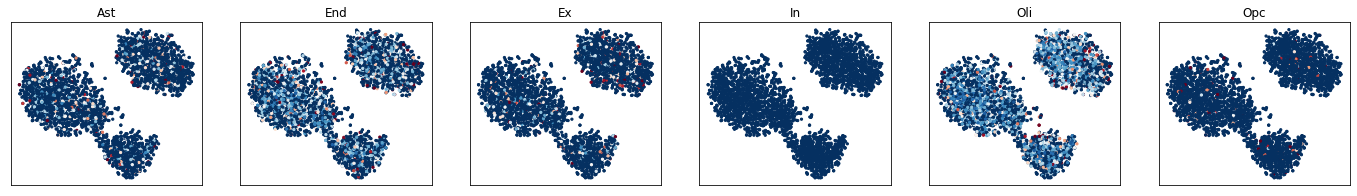

In [210]:
dist = len(set2_ref)/figure
if (dist.is_integer()): 
    dist = int(dist)
    fig, axes = plt.subplots(dist, figure, figsize = ((figure *4), (dist*3)))
else:
    fig, axes = plt.subplots(len(set2_ref), 1, figsize = (3,(len(set2_ref) *4)))
    figure = 1
    
for i, (c, _) in enumerate(set2_ref):
    if(figure == 1 or dist == 1): ax = axes[i]
    else: ax = axes[i // figure, i % figure]
    vmax, vmin = np.percentile(scoresNP[:, i], 99), np.percentile(scoresNP[:, i], 1)
    ax.scatter(df_tsne[:,0], df_tsne[:,1], 
            s = 5, c = scoresNP[:, i], cmap = 'RdBu_r', vmax = vmax, vmin = vmin)
    ax.set_title(c)
    ax.set_xticks([])
    ax.set_yticks([])
#axes[-1,-1].axis('off')

if(outP): plt.savefig(inP + '.png')
plt.show()

In [ ]:
def output():
    if(verbose): print("Outputing")
    #write output file for the intersection
    IntersectFile = open(fn_bk1+'Intersection.tsv', "w+")
    IntersectFile.write("Chr in Data\tChr in Bk\tOverlap percent\n")
    IntersectWriter= csv.writer(IntersectFile, delimiter='\t')
    for line in intersect: IntersectWriter.writerow(line)
    IntersectFile.close()
    
    #write output file for the intersection of cell types
    for c, s2 in set2_ref:
        setFile = open( c+")_Intersection.tsv" , "w+")
        setFile.write("Chr in Data\tChr in Bk\tOverlap percent\n")
        setWriter= csv.writer(setFile, delimiter='\t')
        for line in s2: setWriter.writerow(line)
        setFile.close()
    
    #write output file for fischer exact scores
    ScoreFile = open('DatafischerScores.tsv', "w+")
    ScoreFile.write("Ex\tIn\tMic\tEnd\tAst\tOpc\tOli\n")
    IntersectWriter= csv.writer(IntersectFile, delimiter='\t')
    for line in intersect: IntersectWriter.writerow(line)
    sFile.close()


In [ ]:
if(verbose): print("Outputting")
if(outP) output()